##### Student Name: Dara Leonard
##### Student ID: 19202478

#### Task 1: Identify one or more suitable web APIs

Two web APIs have been identified to investigate if the weather in a certain location has an impact on the top time in a segment on Strava.

The Strava API is openly available and allows for requests to be made for public data and data specific to an individual athlete. The access token is refreshed daily.

The World Weather Online offers an API for historic weather that can be queried with latitude and longitude. This API is no longer freely available but there is a free 60 day trial upon signing up.

In [295]:
import pandas as pd
import requests
import json
from stravalib import Client
import matplotlib.pyplot as plt
import datetime

strava_client = Client(access_token="2edabc73ad1bbe0b7d958463c87cffd9650d4142")
#Personal mail
#weather_api_key = "4a88876129264886896114557202902"
#UCD mail
weather_api_key = "279a976e90e54180934134029202203"
def build_past_weather_request(location, year, month, day):
    return "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=" + weather_api_key + "&q="+ location +"&format=json&date="+ str(year) + "-" + str(month) + "-" + str(day)

def build_average_weather_request(location):
    return "http://api.worldweatheronline.com/premium/v1/weather.ashx?key=" + weather_api_key + "&q="+ location + "&format=json&mca=yes"

#### Task 2: Collect data your chosen API(s)

In [296]:
sw_lat = 53.263329
sw_lng = -9.070642
ne_lat = 53.283310
ne_lng = -9.044810

def execute_strava_requests():
    segments_in_an_area = strava_client.explore_segments(bounds=[sw_lat, sw_lng, ne_lat, ne_lng], activity_type='running') # Get current athlete details
    return [strava_client.get_segment(segment.id) for segment in segments_in_an_area]
 
def execute_weather_request(link):
    response = requests.get(link)
    json_res = response.json()['data']['weather']
    return json_res

def execute_historical_average_climate_request(link):
    response = requests.get(link)
    json_res = response.json()['data']["ClimateAverages"]
    return json_res

def execute_api_requests(segment_info):
    weather_data_columns = ["date", "astronomy", "maxtempC","maxtempF","mintempC","mintempF","avgtempC", "avgtempF", "totalSnow_cm", "sunHour", "uvIndex", "hourly"]
    weather_data_df = pd.DataFrame(columns=weather_data_columns)
    
    average_weather_data_columns = ["start_latitude", "start_longitude", "month"]
    average_weather_data_df = pd.DataFrame(columns=average_weather_data_columns)
    
    segment_info_columns = ["id", "name", "activity_type", "distance", "start_latitude", "start_longitude", "end_latitude",
           "end_longitude", "city", "state", "country", "hazardous", "map_id", "map_polyline", "effort_count",
           "athlete_count", "star_count", "best_time", "best_time_date"]
    segment_info_df = pd.DataFrame(columns=segment_info_columns)
    for i, segment in enumerate(segment_info):
        segment_leader_board = strava_client.get_segment_leaderboard(segment.id)
        best_time = segment_leader_board.entries[0].elapsed_time
        best_time_date = segment_leader_board.entries[0].start_date
        strava_tmp = dict({"id": segment.id,
             "name": segment.name,
             "activity_type": segment.activity_type,
             "distance": segment.distance,
             "start_latitude": segment.start_latitude,
             "start_longitude": segment.start_longitude,
             "end_latitude": segment.end_latitude,
             "end_longitude": segment.end_longitude,
             "city": segment.city,
             "state": segment.state,
             "country": segment.country,
             "hazardous": segment.hazardous,
             "map_id": segment.map.id,
             "map_polyline": segment.map.polyline,
             "effort_count": segment.effort_count,
             "athlete_count": segment.athlete_count,
             "star_count": segment.star_count,
             "best_time" : best_time, 
             "best_time_date" : best_time_date})
        segment_info_df.loc[i] = strava_tmp


        try:
            weather_data = execute_weather_request(build_past_weather_request(str(segment.start_latitude + segment.start_longitude), best_time_date.year, best_time_date.month, best_time_date.day))
        except KeyError:
            weather_data = execute_weather_request(build_past_weather_request(str(sw_lat + sw_lng), best_time_date.year, best_time_date.month, best_time_date.day))
        weather_tmp = dict({"date" : weather_data[0].get('date'),
                    "astronomy" : weather_data[0].get('astronomy'),
                    "maxtempC": weather_data[0].get('maxtempC'),
                    "maxtempF": weather_data[0].get('maxtempF'),
                    "mintempC": weather_data[0].get('mintempC'),
                    "mintempF": weather_data[0].get('mintempF'),
                    "avgtempC": weather_data[0].get('avgtempC'),
                    "avgtempF": weather_data[0].get('avgtempF'),
                    "totalSnow_cm": weather_data[0].get('totalSnow_cm'), 
                    "sunHour": weather_data[0].get('sunHour'), 
                    "uvIndex": weather_data[0].get('uvIndex'), 
                    "hourly": weather_data[0].get('hourly')})
        weather_data_df.loc[i] = weather_tmp
        
        try:
            average_weather_data = execute_historical_average_climate_request(build_average_weather_request(str(segment.start_latitude + segment.start_longitude)))
        except KeyError:
            average_weather_data = execute_historical_average_climate_request(build_average_weather_request(str(sw_lat + sw_lng)))

        average_weather_tmp = dict({
            "start_latitude" : segment.start_latitude,
            "start_longitude" : segment.start_longitude,
            "month" : average_weather_data
        })
        average_weather_data_df.loc[i] = average_weather_tmp

    return segment_info_df, weather_data_df, average_weather_data_df


segment_info_final = execute_strava_requests()
segment_info_df_final, weather_data_df_final, average_weather_data_df_final = execute_api_requests(segment_info_final)

#### Task 3: Parse the collected data, and store it in an appropriate file format

In [297]:
segment_info_df_final.to_json('strava-data.json', orient='records')
weather_data_df_final.to_json('weather-data.json', orient='records')
average_weather_data_df_final.to_json('average-weather-data.json', orient='records')

#### Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data
- Clean data (simplified_data.dtypes.value_counts(), simplified_data.isnull().sum())
- Combine data  - dataframe for average weather data
                - dataframe with one line per segment, incl temp, wind and rain (both average and on that day)
- Plot km/hr v temp, wind and rain (x- axis segments, primary y - km/hr, secondary y - weather). See what one has the biggest affect

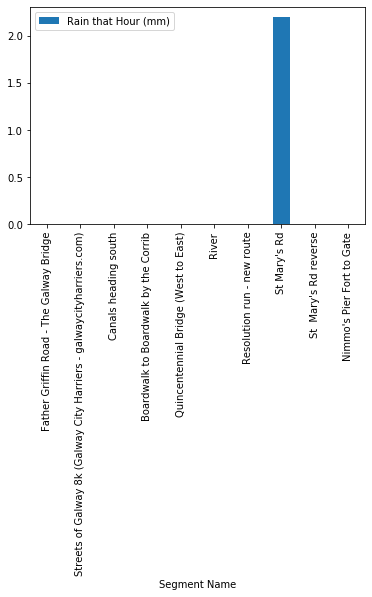

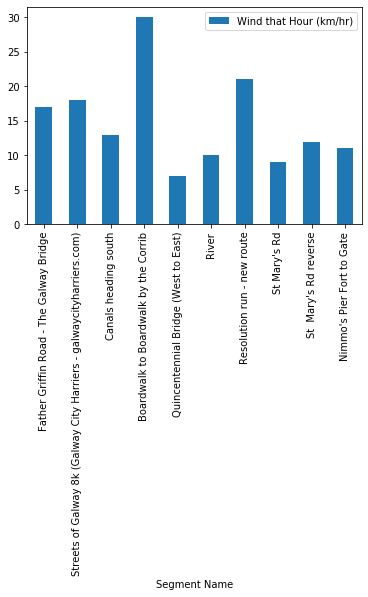

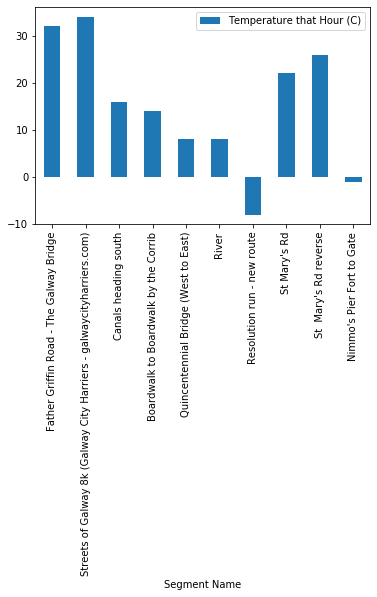

In [298]:
def get_temp_wind_and_rain(pos, rounded_time_value):
    for hour in weather_data['hourly'][pos]:
        if str(hour.get('time')) == str(rounded_time_value):
            return hour.get('tempC'), hour.get('windspeedKmph'), hour.get('precipMM')

def round_to_nearest_300(x, base=300):
    return base * round(x/base)

def get_month_int(pos):
    return int(str(pd.to_datetime(strava_data['best_time_date'][pos], unit='ms').date()).split('-')[1])

def get_average_precipitation_and_average_min_temp(pos):
    for month in average_weather_data['month'][0]:
        return month.get('month')[pos-1].get('avgMinTemp'), month.get('month')[pos-1].get('avgDailyRainfall')

strava_data = pd.read_json('strava-data.json', orient='records')
weather_data = pd.read_json('weather-data.json', orient='records')
average_weather_data = pd.read_json('average-weather-data.json', orient='records')

consolidated_data_columns = ["Segment Name", "City", "Start Latitude", "Start Longitude", "Distance (m)", "Time Taken (s)", "Speed (m/s)", "Date", "Finish Time (Time of Day)", "Rain that Hour (mm)", "Wind that Hour (km/hr)", "Temperature that Hour (C)", "Average Rainfall (mm/day)", "Average Temperature (C)"]
consolidated_df = pd.DataFrame(columns=consolidated_data_columns)

for i in strava_data.index:
    rounded_best_time_value = round_to_nearest_300(int(str(pd.to_datetime(strava_data['best_time_date'][i], unit='ms').time()).replace(':', '')[:-2]))
    temp, wind_speed, precipitation = get_temp_wind_and_rain(i, rounded_best_time_value)
    avrg_tmp, avrg_rain = get_average_precipitation_and_average_min_temp(get_month_int(i))

    tmp_consolidated_data = dict({
        "Segment Name" : strava_data['name'][i],
        "City" : strava_data['city'][i],
        "Start Latitude" : strava_data['start_latitude'][i],
        "Start Longitude" : strava_data['start_longitude'][i],
        "Distance (m)" : strava_data['distance'][i].get('num'),
        "Time Taken (s)" : strava_data['best_time'][i]/1000,
        "Speed (m/s)" : (strava_data['distance'][i].get('num'))/(strava_data['best_time'][i]/1000),
        "Date" : pd.to_datetime(strava_data['best_time_date'][i], unit='ms').date(),
        "Finish Time (Time of Day)" : pd.to_datetime(strava_data['best_time_date'][i], unit='ms').time(),
        "Rain that Hour (mm)" : float(precipitation),
        "Wind that Hour (km/hr)" : float(wind_speed),
        "Temperature that Hour (C)" : float(temp),
        "Average Rainfall (mm/day)" : float(avrg_rain),
        "Average Temperature (C)" : float(avrg_tmp)
    })
    consolidated_df.loc[i] = tmp_consolidated_data

consolidated_df.isnull().sum()

consolidated_df.dtypes.value_counts() 


consolidated_df.plot(kind='bar', x='Segment Name', y='Rain that Hour (mm)')
consolidated_df.plot(kind='bar', x='Segment Name', y='Wind that Hour (km/hr)')
consolidated_df.plot(kind='bar', x='Segment Name', y='Temperature that Hour (C)')

#### Task 5: Analyse and summarise the cleaned dataset




In [299]:
print("Done")

Done
